In [11]:
from google.colab import files
import shutil

uploaded = files.upload()

file_name = next(iter(uploaded))
file_size = os.path.getsize(file_name)
shutil.move('employees.csv', '/content/employees.csv')


Saving employees.csv to employees.csv


'/content/employees.csv'

In [12]:
import os
from google.colab import files
import csv

FILE_PATH = '/content/employees.csv'

with open(FILE_PATH, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    header = next(reader)  # Skip the header row
    record_count = sum(1 for row in reader)
    column_names = reader.fieldnames

print(f"File size: {file_size} bytes")
print(f"Number of records: {record_count}")
print(f"Column names: {column_names}")

File size: 3030111 bytes
Number of records: 19999
Column names: ['eid', 'name', 'title', 'birth_date', 'hire_date', 'address', 'city', 'country', 'postal_code', 'phone', 'salary', 'reports_to']


Existence Assertion Records with missing name: 19
Existence Assertion Records with missing title: 0
Limit Assertion Records hired before 2015: 18
Limit Assertion Salary range between $30,000 - $200,000: 759
Intra-record Assertion Records employee born before they hired: 13
Intra-record Assertion Records employee salary greater than 50000 with title: 0
Inter-record Assertion Records employee has a manager who is a known employee: 7673
Inter-record Assertion Records employee share same phone number: 1
Summary Assertion Record of Cities with only one employee: 10024
Summary Assertion Record of Countries with less than two employee: 0
Statistical Assertion:


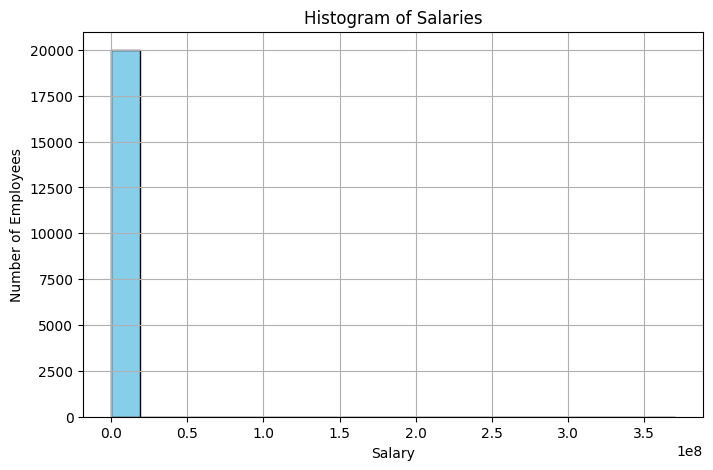


Statistical Assertion Record percentage of employees earn less than $200,000: 95.95%


In [95]:
import pandas as pd
import os
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

FILE_PATH = '/content/employees.csv'

def read_csv(FILE_PATH):
  with open(FILE_PATH, newline='', encoding='utf-8') as csvfile:
      reader = csv.DictReader(csvfile)
      return list(reader)

# This is for existence assertion checking that name and title fields are missing or empty
def validate_existence_assertion(data):

    missing_name = 0
    missing_title = 0

    for row in data:

        # Checking that the name field is missing or empty
        if not row['name'] or row['name'].strip() == '':
                missing_name += 1

        # Checking that the title field is missing or empty
        if not row['title'] or row['title'].strip() == '':
                missing_title += 1

    print(f"Existence Assertion Records with missing name: {missing_name}")
    print(f"Existence Assertion Records with missing title: {missing_title}")

# This is for limit assertion checking if the hire date is before 2015 and the salary is within range
def validate_limit_assertion(data):

    hire_early_date = 0
    salary_range = 0

    for row in data:
      try:
        hire_date = datetime.strptime(row['hire_date'], '%Y-%m-%d')

        if hire_date < datetime(2015, 1, 1):
          hire_early_date += 1

        salary = float(row['salary'])

        if salary < 30000 or salary > 200000:
           salary_range += 1

      except ValueError:
          hire_early_date += 1
          salary_range += 1


    print(f"Limit Assertion Records hired before 2015: {hire_early_date}")
    print(f"Limit Assertion Salary range between $30,000 - $200,000: {salary_range}")

# This is for intra record assertion
def validate_intrarecord_assertion(data):

    hire_before_birth_date = 0
    salary_with_title = 0

    for row in data:
      try:
        birth_date = datetime.strptime(row['birth_date'], '%Y-%m-%d')
        hire_date = datetime.strptime(row['hire_date'], '%Y-%m-%d')

        if birth_date >= hire_date:
           hire_before_birth_date += 1

        # checking that the employee has a title but salary is <= 50,000
        salary = float(row['salary'])
        title = row['title'].strip()

        if title and salary <= 50000:
            salary_with_title += 1

      except ValueError:
        hire_before_birth_date += 1
        salary_with_title += 1

    print(f"Intra-record Assertion Records employee born before they hired: {hire_before_birth_date}")
    print(f"Intra-record Assertion Records employee salary greater than 50000 with title: {salary_with_title}")

# This is for intra record assertion checking that employee has a manager who is a known employee and employees share phone numbers
def validate_interrecord_assertion(data):

  employee_has_manager = 0
  employee_id = set(row['eid'] for row in data if row['eid'].strip())
  phone_counts = {}

  for row in data:
      manager_id = row['reports_to'].strip()

      if manager_id and manager_id not in employee_id:
        employee_has_manager += 1

      # checking that the employees share phone numbers
      phone = row['phone'].strip()
      if phone:
        phone_counts[phone] = phone_counts.get(phone, 0) + 1

  shared_phone_numbers = sum(1 for count in phone_counts.values() if count > 1)

  print(f"Inter-record Assertion Records employee has a manager who is a known employee: {employee_has_manager}")
  print(f"Inter-record Assertion Records employee share same phone number: {shared_phone_numbers}")

# This is for summary assertion checking that the each city has more than one employee and country should have more than 2 employess
def validate_summary_assertion(data):

  employee_each_city = {}
  employee_country_count = {}

  for row in data:
    city = row['city'].strip()

    if city:
        employee_each_city[city] = employee_each_city.get(city, 0) + 1

    one_employee_city = [city for city, count in employee_each_city.items() if count == 1]

    country = row['country'].strip()

    if country:
        employee_country_count[country] = employee_country_count.get(country, 0) + 1

    two_employee_country = [country for country, count in employee_country_count.items() if count == 2]


  print(f"Summary Assertion Record of Cities with only one employee: {len(one_employee_city)}")
  print(f"Summary Assertion Record of Countries with less than two employee: {len(two_employee_country)}")

# This is for statistical assertion to check if salaries are normally distributed
def validate_statistical_assertion(data):

    salaries = []


    for row in data:
        try:
            salary = float(row['salary'])
            salaries.append(salary)
        except ValueError:
            continue

    print("Statistical Assertion:")
    plt.figure(figsize=(8, 5))
    plt.hist(salaries, bins=20, color='skyblue', edgecolor='black')
    plt.title('Histogram of Salaries')
    plt.xlabel('Salary')
    plt.ylabel('Number of Employees')
    plt.grid(True)
    plt.show()


    # New assertion that 95% of people has salary below $200000
    below_200k = sum(1 for s in salaries if s < 200000)
    percentage_below_200k = (below_200k / len(salaries)) * 100

    print(f"\nStatistical Assertion Record percentage of employees earn less than $200,000: {percentage_below_200k:.2f}%")

if __name__ == "__main__":
    data = read_csv(FILE_PATH)
    validate_existence_assertion(data)
    validate_limit_assertion(data)
    validate_intrarecord_assertion(data)
    validate_interrecord_assertion(data)
    validate_summary_assertion(data)
    validate_statistical_assertion(data)